Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# MNIST Training on ASH cluster and storage account



## Prerequisite

*     A Kubernetes cluster deployed on Azure Stack Hub, connected to Azure through ARC.
     
   For details on how to deploy kubernetes cluster on Azure Stack Hub and enabling ARC connection to Azure, please follow [this guide](https://github.com/Azure/AML-Kubernetes/blob/master/docs/ASH/AML-ARC-Compute.md)
  

*     Datastore setup in Azure Machine Learning workspace backed up by Azure Stack Hub storage account.

   [This document](https://github.com/Azure/AML-Kubernetes/blob/master/docs/ASH/Train-AzureArc.md) is a detailed guide on how to create Azure Machine Learning workspace, create a  Azure Stack Hub Storage account, and setup datastore in AML workspace backed by ASH storage account.


*      Last but not least, you need to be able to run a Notebook. 

   If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the configuration Notebook located at [here](https://github.com/Azure/MachineLearningNotebooks) first if you haven't. This sets you up with a working config file that has information on your workspace, subscription id, etc.

## Initialize workspace

Initialize a [Workspace](https://docs.microsoft.com/azure/machine-learning/service/concept-azure-machine-learning-architecture#workspace) object from the existing workspace you created in the Prerequisites step. `Workspace.from_config()` creates a workspace object from the details stored in `config.json`. 

If you haven't done already please go to `config.json` file and fill in your workspace information.

In [1]:
from azureml.core.workspace import Workspace,  ComputeTarget
from azureml.exceptions import ComputeTargetException

ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


Workspace name: sl-ash2-mal
Azure region: eastus
Subscription id: 6b736da6-3246-44dd-a0b8-b5e95484633d
Resource group: sl-ash2


## Prepare dataset

You may download mnist data from [mnist_data](http://yann.lecun.com/exdb/mnist/). For your convenience, we have included under mnist_data folder. There are four files: t10k-images-idx3-ubyte.gz, t10k-labels-idx1-ubyte.gz, train-images-idx3-ubyte.gz and train-labels-idx1-ubyte.gz.  Your next step is to upload these files to datastore of the workspace, and then registered as dataset in the workspace. 

Upload and dataset registration take less than 1 min.

To set up datastore using an azure stack hub storage account, please refer to [Train_azure_arc](https://github.com/Azure/AML-Kubernetes/blob/master/docs/ASH/Train-AzureArc.md). To register the dataset manually, please refer to this [video](https://msit.microsoftstream.com/video/51f7a3ff-0400-b9eb-2703-f1eb38bc6232)


In [2]:
from azureml.core import Workspace, Dataset, Datastore

dataset_name = "mnist_ash_o"
if dataset_name not  in ws.datasets:
    
    datastore_name = "ashstoreolando"
    datastore =  Datastore.get(ws, datastore_name)
    
    src_dir, target_path = 'mnist_data', 'mnistdataash'
    datastore.upload(src_dir, target_path)

    # register data uploaded as AML dataset
    datastore_paths = [(datastore, target_path)]
    pd_ds = Dataset.File.from_files(path=datastore_paths)
    pd_ds.register(ws, dataset_name, "mnist data from http://yann.lecun.com/exdb/mnist/")

## Create or attach existing ArcKubernetesCompute

The attaching code here depends  python package azureml-contrib-k8s which current is in private preview. Install private preview branch of AzureML SDK by running following command (private preview):

<pre>
pip install --disable-pip-version-check --extra-index-url https://azuremlsdktestpypi.azureedge.net/azureml-contrib-k8s-preview/D58E86006C65 azureml-contrib-k8s
</pre>

Attaching ASH cluster the first time may take 7 minutes. It will be much faster after first attachment.

In [3]:
from azureml.contrib.core.compute.arckubernetescompute import ArcKubernetesCompute
from azureml.core import ComputeTarget

resource_id = "/subscriptions/6b736da6-3246-44dd-a0b8-b5e95484633d/resourceGroups/sl-ash2/providers/Microsoft.Kubernetes/connectedClusters/sl-d2-o-arc"

attach_config = ArcKubernetesCompute.attach_configuration(
    resource_id= resource_id,
)

try:
    attach_name = "sl-d2-o-arc"
    arcK_target_result = ArcKubernetesCompute.attach(ws, attach_name, attach_config)
    arcK_target_result.wait_for_completion(show_output=True)
    print('arc attach  success')
except ComputeTargetException as e:
    print(e)
    print('arc attach  failed')

arcK_target = ComputeTarget(ws, attach_name)

SucceededProvisioning operation finished, operation "Succeeded"
arc attach  success


## Configure the training job and Submit a run

### Create an experiement

In [4]:
from azureml.core import Experiment

experiment_name = 'mnist-demo'

exp = Experiment(workspace=ws, name=experiment_name)

### Create an environment

In [5]:
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies

# to install required packages
env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

### Configure the training job

The training takes about 15 mins with vm size comparable  to Standard_DS3_v2

In [6]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', ws.datasets[dataset_name].as_mount(), '--regularization', 0.5]
script_folder =  "mnist_script"
src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py', 
                      arguments=args,
                      compute_target=arcK_target,
                      environment=env)

### Submit job

Run your experiment by submitting your ScriptRunConfig object. Note that this call is asynchronous.

In [7]:
run = exp.submit(config=src)
run.wait_for_completion(show_output=True)  # specify True for a verbose log

RunId: mnist-demo_1613697296_05f7cc01
Web View: https://ml.azure.com/experiments/mnist-demo/runs/mnist-demo_1613697296_05f7cc01?wsid=/subscriptions/6b736da6-3246-44dd-a0b8-b5e95484633d/resourcegroups/sl-ash2/workspaces/sl-ash2-mal

Streaming azureml-logs/20_image_build_log.txt

2021/02/19 01:15:09 Downloading source code...
2021/02/19 01:15:10 Finished downloading source code
2021/02/19 01:15:10 Creating Docker network: acb_default_network, driver: 'bridge'
2021/02/19 01:15:11 Successfully set up Docker network: acb_default_network
2021/02/19 01:15:11 Setting up Docker configuration...
2021/02/19 01:15:11 Successfully set up Docker configuration
2021/02/19 01:15:11 Logging in to registry: slash2acr.azurecr.io
2021/02/19 01:15:13 Successfully logged into slash2acr.azurecr.io
2021/02/19 01:15:13 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/02/19 01:15:13 Scanning for dependencies...
2021/02/19 01:15:13 Successfully scanned 

Ran pip subprocess with arguments:
['/azureml-envs/azureml_f05abada0d8f35e2f68e7d6307f8164c/bin/python', '-m', 'pip', 'install', '-U', '-r', '/azureml-environment-setup/condaenv.r45acm8t.requirements.txt']
Pip subprocess output:
  Created wheel for fusepy: filename=fusepy-3.0.1-py3-none-any.whl size=10504 sha256=87ef975c7e4d2e9c89bc6eb77f67626031f8242e007895128f9b9752495b3561
  Stored in directory: /root/.cache/pip/wheels/21/5c/83/1dd7e8a232d12227e5410120f4374b33adeb4037473105b079
  Created wheel for json-logging-py: filename=json_logging_py-0.2-py3-none-any.whl size=3924 sha256=12f384d1a7b471acc2d628bed0f1a4b3bee362df496ad2c8a4f2b9897791ef05
  Stored in directory: /root/.cache/pip/wheels/e2/1d/52/535a274b9c2ce7d4064838f2bdb62013801281ef7d7f21e2ee
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11730 sha256=c645893cd96aae7acd585fb4eb9a29d54cc00b5c00190d0fc9f927c651312606
  Stored in directory: /root/.cache/pip/wheels/53/ba/da/8562a6a6dbb428fd1ecc21053106df

Removing intermediate container 1e73b19cb4c8
 ---> 8c441ab7d3d7
Step 13/18 : ENV AZUREML_CONDA_ENVIRONMENT_PATH /azureml-envs/azureml_f05abada0d8f35e2f68e7d6307f8164c
 ---> Running in 1f33882a7788
Removing intermediate container 1f33882a7788
 ---> 689b4aa1bce4
Step 14/18 : ENV LD_LIBRARY_PATH /azureml-envs/azureml_f05abada0d8f35e2f68e7d6307f8164c/lib:$LD_LIBRARY_PATH
 ---> Running in 7c04b7401645
Removing intermediate container 7c04b7401645
 ---> 50a5e9b6db78
Step 15/18 : COPY azureml-environment-setup/spark_cache.py azureml-environment-setup/log4j.properties /azureml-environment-setup/
 ---> ac6aa17896a7
Step 16/18 : RUN if [ $SPARK_HOME ]; then /bin/bash -c '$SPARK_HOME/bin/spark-submit  /azureml-environment-setup/spark_cache.py'; fi
 ---> Running in 7d275f4f84dc
Removing intermediate container 7d275f4f84dc
 ---> 8c7e60d48eb7
Step 17/18 : ENV AZUREML_ENVIRONMENT_IMAGE True
 ---> Running in 3afe8ded7fc4
Removing intermediate container 3afe8ded7fc4
 ---> 868f2f11113a
Step 18/18 : CMD [

{'runId': 'mnist-demo_1613697296_05f7cc01',
 'target': 'sl-d2-o-arc',
 'status': 'Completed',
 'startTimeUtc': '2021-02-19T01:15:01.388016Z',
 'endTimeUtc': '2021-02-19T01:46:08.542083Z',
 'properties': {'_azureml.ComputeTargetType': 'arckubernetes',
  'ContentSnapshotId': 'b5c7aaeb-dae2-4bce-917f-f5678c8cfd6c',
  'azureml.git.repository_uri': 'git@github.com:lisongshan007/AML-Kubernetes.git',
  'mlflow.source.git.repoURL': 'git@github.com:lisongshan007/AML-Kubernetes.git',
  'azureml.git.branch': 'master',
  'mlflow.source.git.branch': 'master',
  'azureml.git.commit': '9af78d232734dace4df94ed28a5e6888ed3905e4',
  'mlflow.source.git.commit': '9af78d232734dace4df94ed28a5e6888ed3905e4',
  'azureml.git.dirty': 'False',
  'ProcessInfoFile': 'azureml-logs/process_info.json',
  'ProcessStatusFile': 'azureml-logs/process_status.json'},
 'inputDatasets': [{'dataset': {'id': 'c0414c0d-aaa1-4c65-9b1c-c404dd7fe3ca'}, 'consumptionDetails': {'type': 'RunInput', 'inputName': 'input__8389cfa5', 'mec

### Register Model

In [8]:
# register model
model = run.register_model(model_name='sklearn_mnist',
                           model_path='outputs/sklearn_mnist_model.pkl')

## Test Registered Model

To test the trained model, you can create (or use existing) a AKS cluster for serving the model using AML deployment

In [9]:
from azureml.core import Environment, Workspace, Model, ComputeTarget
from azureml.core.compute import AksCompute
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice, AksWebservice
from azureml.core.compute_target import ComputeTargetException
import numpy as np
import json

### Provision the AKS Cluster

This is a one time setup. You can reuse this cluster for multiple deployments after it has been created. If you delete the cluster or the resource group that contains it, then you would have to recreate it. It may take 5 mins to create a new AKS cluster.

In [10]:
ws = Workspace.from_config()

# Choose a name for your AKS cluster
aks_name = 'aks-service-2'

# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    is_new_compute  = False
    print('Found existing cluster, use it.')
except ComputeTargetException:
    # Use the default configuration (can also provide parameters to customize)
    prov_config = AksCompute.provisioning_configuration()

    # Create the cluster
    aks_target = ComputeTarget.create(workspace = ws, 
                                    name = aks_name, 
                                    provisioning_configuration = prov_config)
    is_new_compute  = True
    
print("using compute target: ", aks_target.name)

Found existing cluster, use it.
using compute target:  aks-service-2


In [11]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig
from azureml.core.environment import Environment
from azureml.core import Workspace
from azureml.core.model import Model

ws = Workspace.from_config()
model = Model(ws, 'sklearn_mnist')


env = Environment('tutorial-env')
cd = CondaDependencies.create(pip_packages=['azureml-dataset-runtime[pandas,fuse]', 'azureml-defaults'], conda_packages = ['scikit-learn==0.22.1'])

env.python.conda_dependencies = cd

inference_config = InferenceConfig(entry_script="score.py", environment=env)
deploy_config = AksWebservice.deploy_configuration()

service = Model.deploy(workspace=ws, 
                       name='sklearn-mnist-svc', 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_target=aks_target,
                       deployment_config=deploy_config,
                       overwrite=True)

service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running.................
Succeeded
AKS service creation operation finished, operation "Succeeded"
Wall time: 1min 42s


### Load test data

Load the test data from the ./data/ directory created during the training tutorial.

In [12]:
from mnist_script.utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'mnist_data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [13]:
y_hat

[7,
 2,
 1,
 0,
 4,
 1,
 4,
 9,
 6,
 9,
 0,
 6,
 9,
 0,
 1,
 5,
 9,
 7,
 3,
 4,
 9,
 6,
 6,
 5,
 4,
 0,
 7,
 4,
 0,
 1,
 3,
 1,
 3,
 4,
 7,
 2,
 7,
 1,
 3,
 1,
 1,
 7,
 4,
 2,
 3,
 5,
 1,
 2,
 4,
 4,
 6,
 3,
 5,
 5,
 6,
 0,
 4,
 1,
 9,
 5,
 7,
 8,
 9,
 2,
 7,
 4,
 6,
 4,
 3,
 0,
 7,
 0,
 2,
 9,
 1,
 7,
 3,
 2,
 9,
 7,
 7,
 6,
 2,
 7,
 8,
 4,
 7,
 3,
 6,
 1,
 3,
 6,
 9,
 3,
 1,
 4,
 1,
 7,
 6,
 9,
 6,
 0,
 5,
 4,
 9,
 9,
 2,
 1,
 9,
 4,
 8,
 7,
 3,
 9,
 7,
 4,
 4,
 4,
 9,
 2,
 5,
 4,
 7,
 6,
 4,
 9,
 0,
 5,
 8,
 5,
 6,
 6,
 5,
 7,
 8,
 1,
 0,
 1,
 6,
 4,
 6,
 7,
 3,
 1,
 7,
 1,
 8,
 2,
 0,
 9,
 9,
 8,
 5,
 5,
 1,
 5,
 6,
 0,
 3,
 4,
 4,
 6,
 5,
 4,
 6,
 5,
 4,
 5,
 1,
 4,
 4,
 7,
 2,
 3,
 2,
 7,
 1,
 8,
 1,
 8,
 1,
 8,
 5,
 0,
 8,
 9,
 2,
 5,
 0,
 1,
 1,
 1,
 0,
 3,
 0,
 5,
 1,
 6,
 4,
 2,
 3,
 6,
 1,
 1,
 1,
 3,
 9,
 5,
 2,
 9,
 4,
 7,
 9,
 3,
 9,
 0,
 3,
 5,
 5,
 5,
 7,
 2,
 2,
 7,
 1,
 2,
 8,
 4,
 1,
 7,
 3,
 3,
 8,
 7,
 7,
 9,
 2,
 2,
 4,
 1,
 5,
 8,
 8,
 7,
 2,
 5,
 0,
 6,
 4,
 2,


In [15]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

[[ 960    0    2    2    1    4    6    3    1    1]
 [   0 1113    3    1    0    1    5    1   11    0]
 [   9    8  919   20    9    5   10   12   37    3]
 [   4    0   17  918    2   24    4   11   21    9]
 [   1    4    4    3  913    0   10    3    5   39]
 [  10    2    0   42   11  768   17    7   28    7]
 [   9    3    7    2    6   20  907    1    3    0]
 [   2    9   22    5    8    1    1  948    5   27]
 [  10   15    5   21   15   26    7   11  852   12]
 [   7    8    2   14   32   13    0   26   12  895]]
Overall accuracy: 0.9193


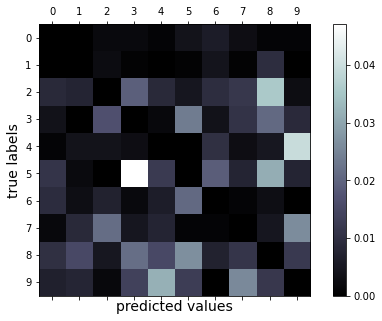

In [16]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
import matplotlib.pyplot as plt

row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('confusion.png')
plt.show()

### Show predictions

Test the deployed model with a random sample of 30 images from the test data.

Print the returned predictions and plot them along with the input images. Red font and inverse image (white on black) is used to highlight the misclassified samples.
Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

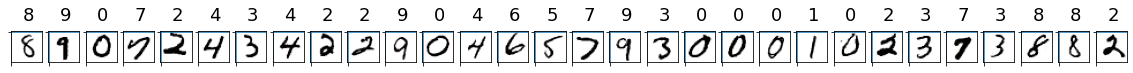

In [17]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y=-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

### Delete the newly created cluster

Note: This is important if you wish to avoid the cost of this cluster

In [ ]:
if is_new_compute:
    aks_target.delete()
    service.delete()

## Next Steps

1. Learn how to [distributed training with pytorch](../distributed-cifar10/distributed-pytorch-cifar10.ipynb)
2. Learn how to [distributed training with tensorflow](../distributed-cifar10/distributed-tf2-cifar10.ipynb)
3. Learn Pipeline Steps with [Object Segmentation](../object-segmentation-on-azure-stack/)